## Goal 
Predict the likelihood of a foreign scientist migrating to the US better than baseline.

### Importing Modules 

In [1]:
# binary classification
import scipy
print('scipy: {}'.format(scipy.__version__)) # numpy
import numpy as np
print('numpy: {}'.format(np.__version__))
# matplotlib
import matplotlib 
import matplotlib.pyplot as plt
print('matplotlib: {}'.format(matplotlib.__version__)) # pandas
import pandas as pd
print('pandas: {}'.format(pd.__version__))
# scikit-learn
import sklearn
print('sklearn: {}'.format(sklearn.__version__))

import datetime
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
import ml_metrics as metrics
from sklearn.metrics import classification_report
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

scipy: 0.19.1
numpy: 1.13.3
matplotlib: 2.0.2
pandas: 0.20.1
sklearn: 0.19.0


/Users/macg/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Reading Data Files

In [2]:
data = pd.read_csv("/Users/macg/Desktop/ORCID_migrations.csv",index_col='orcid_id')
data.head()

,phd_year,country_2016,earliest_year,earliest_country,has_phd,phd_country,has_migrated
orcid_id,,,,,,,
0000-0001-5000-0138,NaN,CO,2014.0,CO,False,NaN,False
0000-0001-5000-0736,2006.0,NaN,NaN,NaN,True,PT,False
0000-0001-5000-1018,2015.0,US,2005.0,US,True,US,False
0000-0001-5000-1181,NaN,RU,1978.0,RU,False,NaN,False
0000-0001-5000-1923,2016.0,GB,2004.0,GB,True,GB,False


In [3]:
data_detail = pd.read_csv("/Users/macg/Desktop/ORCID_migration_detail.csv", encoding = 'iso-8859-1',index_col='Unnamed: 0')
data_detail.head()

,orcid_id,country,organization_name,Ringgold_id,start_year,end_year,affiliation_type,affiliation_role,is_phd
0,0000-0001-5000-0138,CO,Universidad Del Rosario,25807,2014.0,2016.0,EMPLOYMENT,Profesor Principal,False
1,0000-0001-5000-0736,PT,"Faculty of Science and Technology, New Univers...",NaN,NaN,NaN,EMPLOYMENT,PhD in Geology - Invited Assistant Professor,True
2,0000-0001-5000-0736,PT,Universidade de Ìävora Ìrea Departamental de ...,98820,NaN,2006.0,EDUCATION,PhD in Geology,True
3,0000-0001-5000-0736,PT,Universidade de Lisboa,37809,NaN,1997.0,EDUCATION,MSc in Internal Geodynamics,False
4,0000-0001-5000-0736,PT,Universidade de Lisboa,37809,NaN,1992.0,EDUCATION,Graduation in Geology,False


In [4]:
data_detail.shape

(1048575, 9)

In [5]:
len(data_detail) - data_detail.count()

orcid_id                  0
country                  80
organization_name        11
Ringgold_id          283749
start_year           169003
end_year             125701
affiliation_type          1
affiliation_role     107064
is_phd                    0
dtype: int64

In [6]:
# drop columns where we can't tell if this is the earliest affiliation information
data_detail.dropna(subset = ['start_year'], inplace = True)

In [7]:
earliest_year = data_detail[['orcid_id','start_year']]

In [8]:
earliest_year = pd.DataFrame(earliest_year.groupby('orcid_id').min(), columns=['start_year'])

In [9]:
earliest_year.reset_index(inplace = True)

In [10]:
early_detail = data_detail.merge(earliest_year, how='inner',right_on=['orcid_id','start_year'], left_on=['orcid_id','start_year'])

In [11]:
early_detail.set_index('orcid_id',inplace = True)

In [12]:
scientists = data.merge(early_detail, how='inner', left_index=True, right_index=True)
scientists.head()

,phd_year,country_2016,earliest_year,earliest_country,has_phd,phd_country,has_migrated,country,organization_name,Ringgold_id,start_year,end_year,affiliation_type,affiliation_role,is_phd
orcid_id,,,,,,,,,,,,,,,
0000-0001-5000-0138,NaN,CO,2014.0,CO,False,NaN,False,CO,Universidad Del Rosario,25807,2014.0,2016.0,EMPLOYMENT,Profesor Principal,False
0000-0001-5000-1018,2015.0,US,2005.0,US,True,US,False,US,University of Wisconsin Milwaukee,14751,2005.0,2010.0,EDUCATION,B.S. Electrical and Computer Engineering,False
0000-0001-5000-1181,NaN,RU,1978.0,RU,False,NaN,False,RU,_÷__â_üâÄâ ã_ü_á_üà_µ_¼____ _¼Ä_ÈÎ...,NaN,1978.0,1982.0,EDUCATION,âÄ_«_µ__â,False
0000-0001-5000-1923,2016.0,GB,2004.0,GB,True,GB,False,GB,Durham University - Queens Campus,145277,2004.0,2007.0,EDUCATION,BSc (Hons) Applied Psychology,False
0000-0001-5000-223X,1998.0,GB,1989.0,GB,True,GB,True,GB,University of Manchester,5292,1989.0,1993.0,EDUCATION,BSc (Hons.) Applied Plant Sciences,False


In [13]:
scientists.shape

(330581, 15)

### Reordering Columns for Readability

In [14]:
scientists.columns

Index(['phd_year', 'country_2016', 'earliest_year', 'earliest_country',
       'has_phd', 'phd_country', 'has_migrated', 'country',
       'organization_name', 'Ringgold_id', 'start_year', 'end_year',
       'affiliation_type', 'affiliation_role', 'is_phd'],
      dtype='object')

In [15]:
scientists = scientists[['earliest_year', 'earliest_country','country','start_year', 'end_year',
       'organization_name', 'Ringgold_id', 'affiliation_type', 'affiliation_role',
       'has_phd', 'is_phd','phd_country', 'phd_year','has_migrated', 'country_2016']]

### Does Ringgold_id give away US_Migrant status?

In [16]:
org_locations = scientists[['Ringgold_id','country']]

In [17]:
org_locations.dropna(subset = ['country'], inplace = True)

In [18]:
org_locations.shape

(330565, 2)

In [19]:
org_locations.dropna(subset = ['Ringgold_id'], inplace = True)

In [20]:
org_locations.shape

(241653, 2)

In [21]:
org_locations.drop_duplicates(inplace = True)

### Plot the Organizations Associated with the Most Distinct Countries

In [22]:
org_locations['Ringgold_id'].value_counts().head(20)

4919      13
6396      13
1877       7
239757     7
339766     5
2167       5
14724      5
1259       5
2152       4
7088       4
424320     4
66906      4
3489       4
16724      4
61963      4
8082       4
3163       4
14736      3
2129       3
158768     3
Name: Ringgold_id, dtype: int64

In [23]:
org_values = pd.DataFrame(org_locations['Ringgold_id'].value_counts().head(20), columns=['Ringgold_id'])

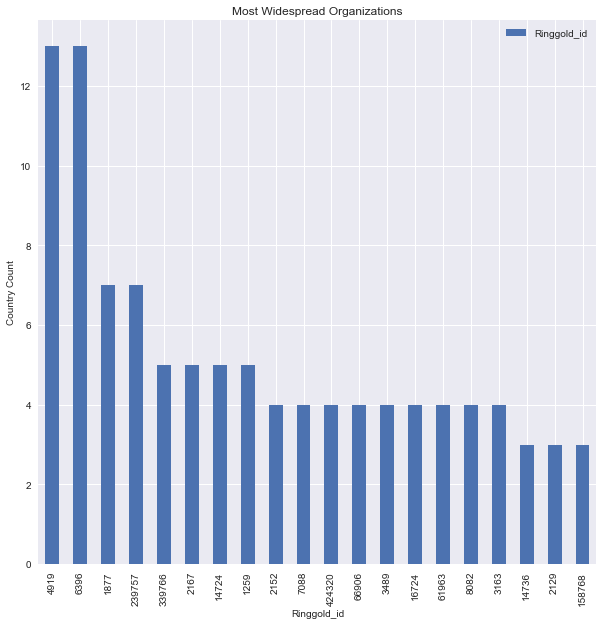

In [24]:
ax = org_values.plot(kind = 'bar',title='Most Widespread Organizations',figsize=(10,10))

ax.set_xlabel("Ringgold_id", fontsize =10)

ax.set_ylabel("Country Count", fontsize =10)

In [25]:
### University of Oxford (Ringgold_id 6396) is the most international organization in the dataset
org_locations[org_locations['Ringgold_id']=='6396']
### Ringgold_id does not necessarily give away US_migrant status, but it could potentially ruin model

,Ringgold_id,country
orcid_id,,
0000-0001-5033-5069,6396,GB
0000-0001-5273-3335,6396,EG
0000-0001-6761-7273,6396,RU
0000-0001-7355-1055,6396,PK
0000-0001-7721-6799,6396,IT
0000-0001-8169-1154,6396,IR
0000-0001-8214-0127,6396,CN
0000-0001-8269-9633,6396,BR
0000-0001-8995-983X,6396,TH


In [26]:
len(scientists) - scientists.count()

earliest_year             0
earliest_country         16
country                  16
start_year                0
end_year                  0
organization_name         2
Ringgold_id           88916
affiliation_type          0
affiliation_role      26370
has_phd                   0
is_phd                    0
phd_country          173203
phd_year             177044
has_migrated              0
country_2016          55928
dtype: int64

In [27]:
scientists['country_2016'].fillna(scientists['country'], inplace=True)

''

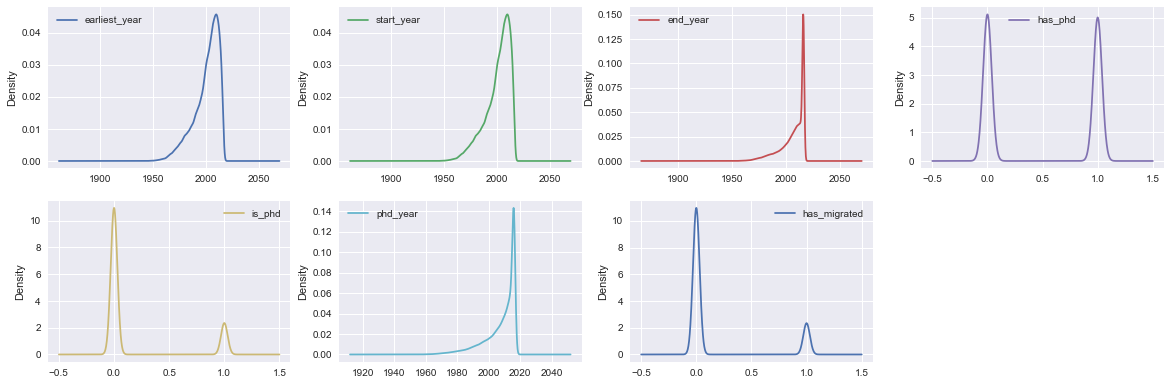

In [28]:
# how many migrants?
# feature distribution:
scientists.plot(kind='density', figsize=(20, 35), layout=(10,4), subplots=True, sharex=False)
;
# class imbalance issue, both migrants and US migrants make up a relatively small subset of scientists
# more on this in model creation phase, but boosting

## Target Setting

In [29]:
def us_migrant(x):
    
    has_migrated, country_2016, earliest_country = x
    
    if has_migrated == 1 and country_2016 == 'US' and earliest_country != 'US':
        return True
    else:
        return False

In [30]:
scientists['US_Migrant'] = scientists[['has_migrated', 'country_2016','earliest_country']].apply(us_migrant, axis=1)
scientists.head()

,earliest_year,earliest_country,country,start_year,end_year,organization_name,Ringgold_id,affiliation_type,affiliation_role,has_phd,is_phd,phd_country,phd_year,has_migrated,country_2016,US_Migrant
orcid_id,,,,,,,,,,,,,,,,
0000-0001-5000-0138,2014.0,CO,CO,2014.0,2016.0,Universidad Del Rosario,25807,EMPLOYMENT,Profesor Principal,False,False,NaN,NaN,False,CO,False
0000-0001-5000-1018,2005.0,US,US,2005.0,2010.0,University of Wisconsin Milwaukee,14751,EDUCATION,B.S. Electrical and Computer Engineering,True,False,US,2015.0,False,US,False
0000-0001-5000-1181,1978.0,RU,RU,1978.0,1982.0,_÷__â_üâÄâ ã_ü_á_üà_µ_¼____ _¼Ä_ÈÎ...,NaN,EDUCATION,âÄ_«_µ__â,False,False,NaN,NaN,False,RU,False
0000-0001-5000-1923,2004.0,GB,GB,2004.0,2007.0,Durham University - Queens Campus,145277,EDUCATION,BSc (Hons) Applied Psychology,True,False,GB,2016.0,False,GB,False
0000-0001-5000-223X,1989.0,GB,GB,1989.0,1993.0,University of Manchester,5292,EDUCATION,BSc (Hons.) Applied Plant Sciences,True,False,GB,1998.0,True,GB,False


### Drop leaky and redundant columns

In [31]:
scientists.drop('country',axis=1,inplace = True)
scientists.drop('start_year',axis=1,inplace=True)
scientists.drop('organization_name', axis=1,inplace = True)
scientists.drop('is_phd', axis=1,inplace = True)
scientists.drop('phd_country',axis=1,inplace=True)
scientists.drop('has_migrated',axis=1,inplace=True)
scientists.drop('country_2016',axis=1,inplace=True)

In [32]:
# how many scientists in this data set are US Natives?
len(scientists[scientists['earliest_country'] =='US'])

52872

### Working Dataset

In [33]:
# select only foreign born scientists
f_scientists = scientists[scientists['earliest_country'] !='US']

In [34]:
# drop cases where we cannot tell if they are US born, migrants, or other
f_scientists.dropna(axis=0, how='any', thresh=None, subset=['earliest_country'], inplace=True)

In [35]:
f_scientists.drop_duplicates(inplace=True)

In [36]:
f_scientists.to_csv("/Users/macg/Desktop/f_scientists.csv")

### Exploratory Data Analysis

In [37]:
f_scientists.shape

(263762, 9)

### How many missing values?

In [38]:
# drop phd_year?
# drop Ringgold_id
len(f_scientists) - f_scientists.count()

earliest_year            0
earliest_country         0
end_year                 0
Ringgold_id          71523
affiliation_type         0
affiliation_role     18521
has_phd                  0
phd_year            144347
US_Migrant               0
dtype: int64

### Investigate further leaks and problem features

In [39]:
# How many scientists have a phd?
# How many scientists have a phd and are missing phd year?

len(f_scientists[f_scientists['has_phd']== True])

doctors = f_scientists[f_scientists['has_phd']== True]

doctors[doctors['phd_year'].isnull()]

print(len(doctors)- len(doctors[doctors['phd_year'].isnull()]))
print(len(doctors))
print (119415/128394)

# 93% of scientists with PhDs have a phd_year

119415
128394
0.9300668255525959


In [40]:
doctors.phd_year.mean()

2008.4932378679396

In [41]:
f_scientists.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263762 entries, 0000-0001-5000-0138 to 0000-0002-5528-3154
Data columns (total 9 columns):
earliest_year       263762 non-null float64
earliest_country    263762 non-null object
end_year            263762 non-null float64
Ringgold_id         192239 non-null object
affiliation_type    263762 non-null object
affiliation_role    245241 non-null object
has_phd             263762 non-null bool
phd_year            119415 non-null float64
US_Migrant          263762 non-null bool
dtypes: bool(2), float64(3), object(4)
memory usage: 16.6+ MB


In [42]:
f_scientists.describe()

,earliest_year,end_year,phd_year
count,263762.000000,263762.000000,119415.000000
mean,2000.444909,2006.883133,2008.493238
std,11.503786,10.839454,9.345386
min,1913.000000,1917.000000,1953.000000
25%,1994.000000,2002.000000,2005.000000
50%,2003.000000,2011.000000,2012.000000
75%,2009.000000,2016.000000,2016.000000
max,2017.000000,2019.000000,2017.000000


In [43]:
# How many US migrants are there?
us_migrants =f_scientists[f_scientists['US_Migrant']==True]

len(us_migrants)
#7727 US migrants
# only 3% of foreign scientists in the dataset are US migrants

7727

In [44]:
migrant_doctors = pd.crosstab(index=[f_scientists.has_phd], columns=[f_scientists.US_Migrant])
migrant_doctors.columns = [['Not US Migrant','US Migrant']]
migrant_doctors
# Doctors seem much more likely to migrate to the US than non-doctors. How much is a function of age vs skilled worker
# attraction?

,Not US Migrant,US Migrant
has_phd,,
False,133711,1657
True,122324,6070


In [45]:
skew = f_scientists.skew()
print(skew)

earliest_year   -1.107296
end_year        -1.438655
has_phd          0.052900
phd_year        -1.669959
US_Migrant       5.582620
dtype: float64


### Feature Imputation

In [46]:
def phd_age(x):
    
    has_phd, earliest_year, phd_year = x
    
    if has_phd == 1 and earliest_year != phd_year:
        return phd_year-earliest_year
    else:
        return

In [47]:
f_scientists['phd_age'] = f_scientists[['has_phd', 'earliest_year','phd_year']].apply(phd_age, axis=1)
f_scientists.head()

,earliest_year,earliest_country,end_year,Ringgold_id,affiliation_type,affiliation_role,has_phd,phd_year,US_Migrant,phd_age
orcid_id,,,,,,,,,,
0000-0001-5000-0138,2014.0,CO,2016.0,25807,EMPLOYMENT,Profesor Principal,False,NaN,False,NaN
0000-0001-5000-1181,1978.0,RU,1982.0,NaN,EDUCATION,âÄ_«_µ__â,False,NaN,False,NaN
0000-0001-5000-1923,2004.0,GB,2007.0,145277,EDUCATION,BSc (Hons) Applied Psychology,True,2016.0,False,12.0
0000-0001-5000-223X,1989.0,GB,1993.0,5292,EDUCATION,BSc (Hons.) Applied Plant Sciences,True,1998.0,False,9.0
0000-0001-5000-3822,1998.0,CA,2002.0,3158,EDUCATION,"Bachelor of Design, Visual Communications",True,2016.0,False,18.0


In [48]:
f_scientists.affiliation_role.nunique()

82579

In [49]:
f_scientists.affiliation_role = f_scientists.affiliation_role.str.lower()

In [50]:
f_scientists.affiliation_role.nunique()

76083

In [51]:
# classifying affiliation role into most common types using list of most common areas of study according to NSF
# doctorates from 1985 to 2014

In [52]:
life_sci =['agri', 'agricultur','bio','medi','natur']
ls_terms = '|'.join(life_sci)
phys_sci = ['chem','comp','geo','math','phys','astro']
ps_terms = '|'.join(phys_sci)
soc_sci = ['anthr','econ','poli','psy','socio']
soc_terms = '|'.join(soc_sci)
eng = ['aero','astro','chem','civ','engin','elec','manu','material','mech']
eng_terms = '|'.join(eng)
hum = ['lang','letter','hist']
hum_terms = '|'.join(hum)
educ = ['educ','admin','teach']
educ_terms = '|'.join(educ)

In [53]:
f_scientists['life_science']= f_scientists.affiliation_role.str.contains(ls_terms)
f_scientists['physical_science']= f_scientists.affiliation_role.str.contains(ps_terms)
f_scientists['social_science']= f_scientists.affiliation_role.str.contains(soc_terms)
f_scientists['engineering']= f_scientists.affiliation_role.str.contains(eng_terms)
f_scientists['humanities']= f_scientists.affiliation_role.str.contains(hum_terms)
f_scientists['education']= f_scientists.affiliation_role.str.contains(educ_terms)

In [54]:
f_scientists[f_scientists['life_science']==True]

,earliest_year,earliest_country,end_year,Ringgold_id,affiliation_type,affiliation_role,has_phd,phd_year,US_Migrant,phd_age,life_science,physical_science,social_science,engineering,humanities,education
orcid_id,,,,,,,,,,,,,,,,
0000-0001-5002-0227,1990.0,AU,2016.0,5673,EMPLOYMENT,professor of agricultural biotechnology,False,NaN,False,NaN,True,False,False,False,False,False
0000-0001-5002-2126,2008.0,CN,2012.0,47890,EDUCATION,bachelor in biotechnology,False,NaN,False,NaN,True,False,False,False,False,False
0000-0001-5002-2708,1995.0,GB,2016.0,NaN,EMPLOYMENT,professor of molecular plant biology,False,NaN,False,NaN,True,False,False,False,False,False
0000-0001-5003-299X,2006.0,IR,2010.0,48437,EDUCATION,b.sc - biomedical engineering,False,NaN,False,NaN,True,False,False,True,False,False
0000-0001-5003-6018,1996.0,VE,2007.0,227274,EDUCATION,licenciada en biologia,False,NaN,False,NaN,True,False,False,False,False,False
0000-0001-5003-6595,2004.0,BR,2006.0,37903,EDUCATION,master in molecular and cell biology,False,NaN,False,NaN,True,False,False,False,False,False
0000-0001-5004-5459,2006.0,BR,2010.0,67825,EDUCATION,biologist,False,NaN,False,NaN,True,False,False,False,False,False
0000-0001-5004-7315,2006.0,ES,2011.0,16754,EDUCATION,biochemistry,False,NaN,False,NaN,True,True,False,True,False,False
0000-0001-5006-0819,1996.0,DE,2002.0,9379,EDUCATION,diplom biologe,True,2006.0,False,10.0,True,False,False,False,False,False


In [55]:
def other_field(x):
    
    life_science, physical_science, social_science, engineering, humanities, education = x
    
    if life_science == False and physical_science == False and social_science == False and engineering == False and humanities == False and education == False:
        return True
    else:
        return False

In [56]:
f_scientists['other'] = f_scientists[['life_science', 'physical_science', 'social_science', 'engineering', 'humanities', 'education']].apply(other_field, axis=1)

### Review Summary Statistics

In [57]:
f_scientists['US_Migrant'].value_counts('orcid_id')

False    0.970705
True     0.029295
Name: US_Migrant, dtype: float64

## Exploratory Data Analysis

### Plot feature distributions 

In [58]:
f_scientists.dtypes

earliest_year       float64
earliest_country     object
end_year            float64
Ringgold_id          object
affiliation_type     object
affiliation_role     object
has_phd                bool
phd_year            float64
US_Migrant             bool
phd_age             float64
life_science         object
physical_science     object
social_science       object
engineering          object
humanities           object
education            object
other                  bool
dtype: object

In [59]:
f_scientists.life_science= f_scientists.life_science.astype('bool')
f_scientists.physical_science= f_scientists.physical_science.astype('bool')
f_scientists.social_science= f_scientists.social_science.astype('bool')
f_scientists.engineering= f_scientists.engineering.astype('bool')
f_scientists.humanities= f_scientists.humanities.astype('bool')
f_scientists.education= f_scientists.education.astype('bool')

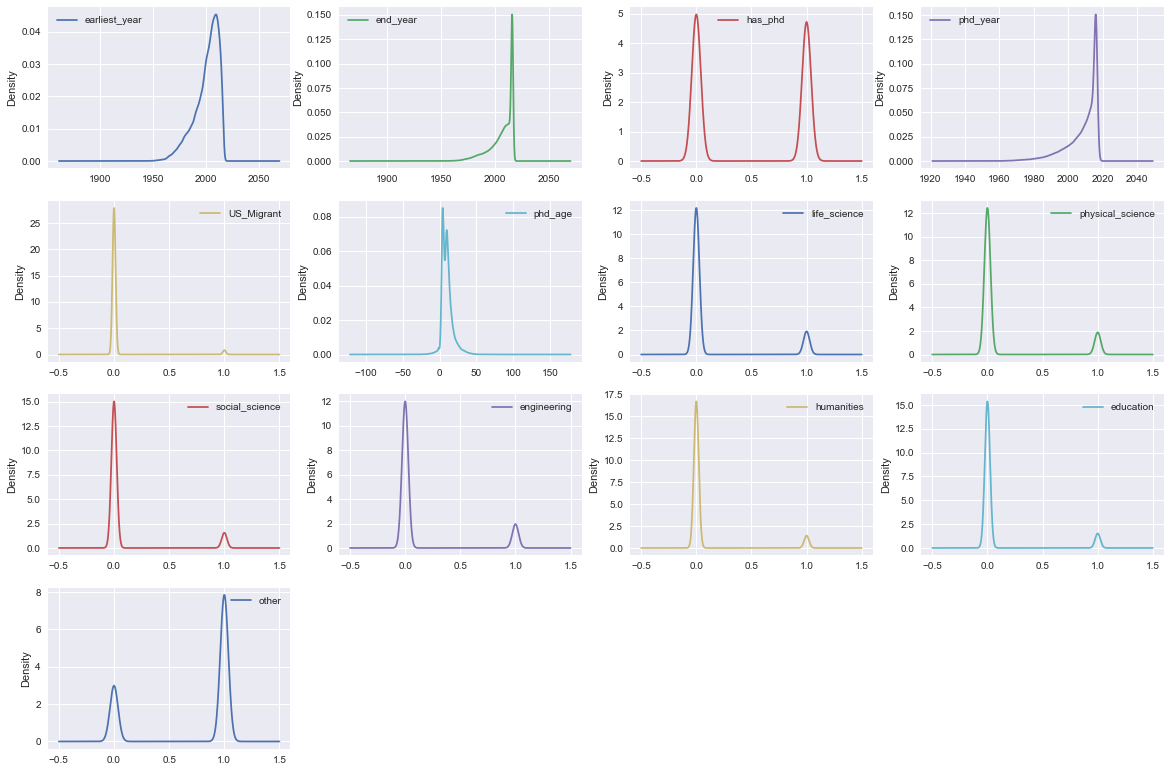

In [60]:
# still the majority of fields remain uncategorized, but not by that much
f_scientists.plot(kind='density', figsize=(20, 35), layout=(10,4), subplots=True, sharex=False) 
plt.show()

### Where do most foreign orcid scientists come from?

In [61]:
scientist_countries = f_scientists.reset_index()
scientist_countries = scientist_countries[['earliest_country','orcid_id']]

''

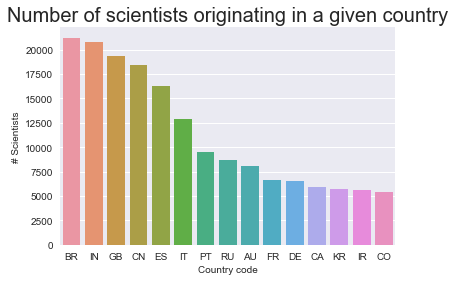

In [62]:
most = scientist_countries.groupby("earliest_country").count().sort_values(by='orcid_id', ascending = False).head(15)
most["earliest_country"] = most.index
plt.title("Number of scientists originating in a given country", fontsize=20)
sns.barplot(x="earliest_country", y="orcid_id", data=most)
plt.ylabel('# Scientists', fontsize=10)
plt.xlabel('Country code', fontsize=10)
;

### Where do most US Migrants come from?

In [63]:
us_migrants = f_scientists[f_scientists['US_Migrant']==True].reset_index()
us_migrants = us_migrants[['earliest_country','orcid_id']]

''

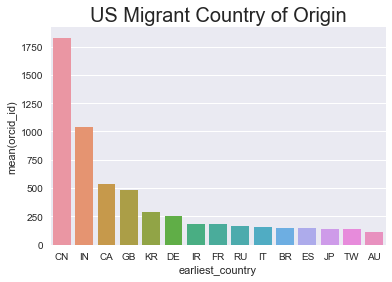

In [64]:
most_us = us_migrants.groupby("earliest_country").count().sort_values(by='orcid_id', ascending = False).head(15)
most_us['earliest_country'] = most_us.index
plt.title('US Migrant Country of Origin', fontsize=20)
sns.barplot(x='earliest_country', y='orcid_id', data=most_us)
;

### Box Plots of Numerical Features

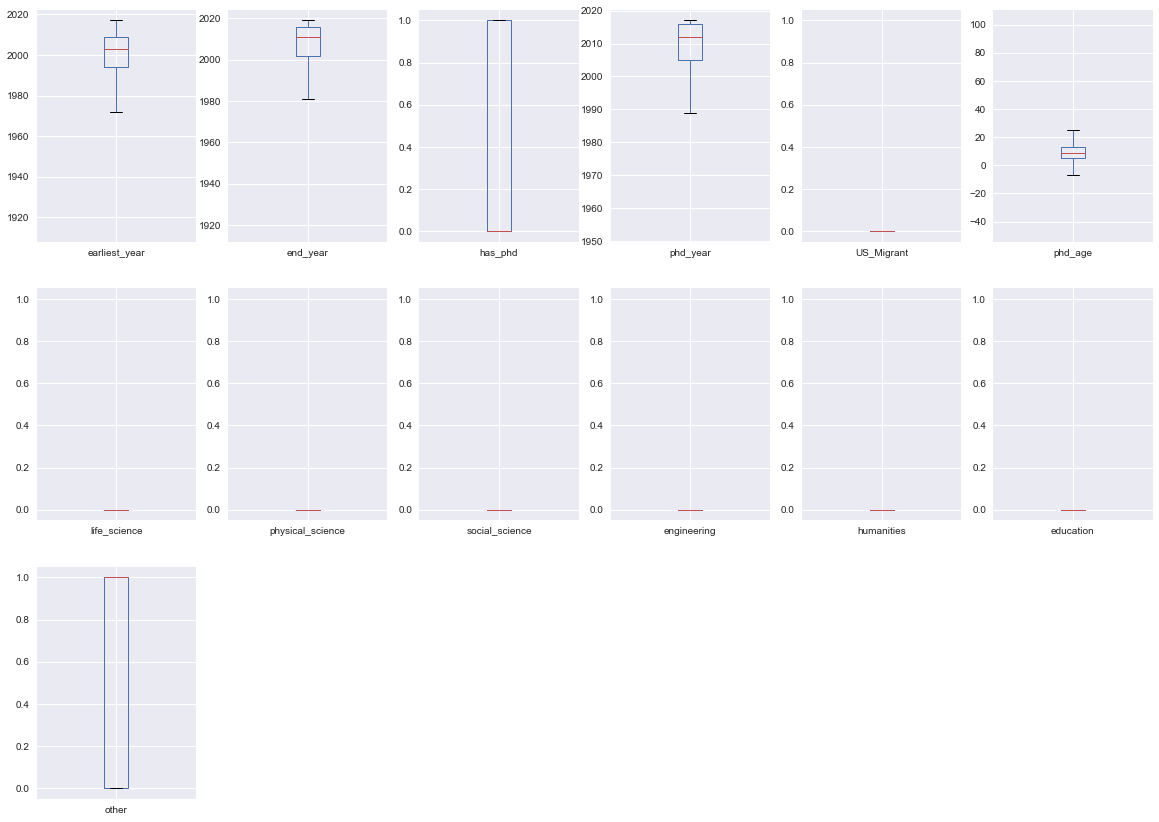

In [65]:
f_scientists.plot(kind='box', subplots=True, figsize=(20, 35), layout=(7,6), sharex=False, sharey=False) 
plt.show()

<module 'matplotlib.pyplot' from '/Users/macg/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

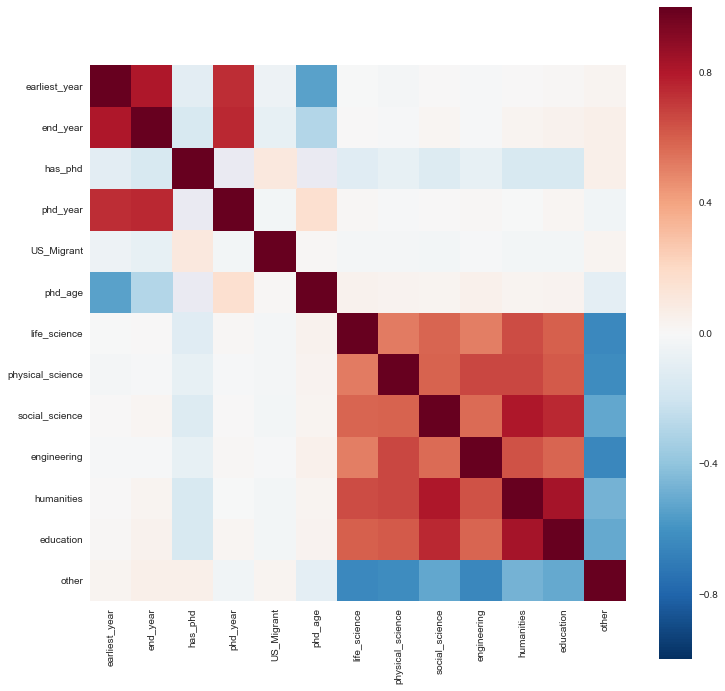

In [66]:
# non-leaky numerical features are not very strong correlates of US Migrant status

corr = f_scientists.select_dtypes(include = ['float64', 'int64','bool']).iloc[:, :].corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, vmax=1, square=True)
sns.plt

### Prepping Categorical Features for Model

In [67]:
len(f_scientists)-f_scientists.count()

earliest_year            0
earliest_country         0
end_year                 0
Ringgold_id          71523
affiliation_type         0
affiliation_role     18521
has_phd                  0
phd_year            144347
US_Migrant               0
phd_age             146214
life_science             0
physical_science         0
social_science           0
engineering              0
humanities               0
education                0
other                    0
dtype: int64

In [68]:
missing_org = f_scientists[f_scientists['Ringgold_id'].isnull()==True].reset_index()

In [69]:
miss_org_dist = pd.crosstab(index=[missing_org.has_phd], columns=[missing_org.US_Migrant])
#migrant_doctors.columns = [['Not US Migrant','US Migrant']]
miss_org_dist

US_Migrant,False,True
has_phd,,
False,38680,287
True,31542,1014


In [70]:
f_scientists.shape

(263762, 17)

### Dealing with missing values

In [71]:
print("% of scientists missing an org:",71523/263762)

% of scientists missing an org: 0.271164913823826


In [72]:
f_scientists = f_scientists.drop(['Ringgold_id'], axis=1)

### Affiliation_role

In [73]:
f_scientists['affiliation_role'].fillna(f_scientists['affiliation_type'], inplace=True)

### phd_year & age

In [74]:
f_scientists['phd_year'].fillna(0,inplace=True)
f_scientists['phd_age'].fillna(0,inplace=True)

In [75]:
len(f_scientists)-f_scientists.count()

earliest_year       0
earliest_country    0
end_year            0
affiliation_type    0
affiliation_role    0
has_phd             0
phd_year            0
US_Migrant          0
phd_age             0
life_science        0
physical_science    0
social_science      0
engineering         0
humanities          0
education           0
other               0
dtype: int64

### Identify Categorical Features

In [76]:
print(f_scientists.select_dtypes(include=['object']).columns.values)

['earliest_country' 'affiliation_type' 'affiliation_role']


### One Hot Encoder

In [77]:
f_scientists.dtypes

earliest_year       float64
earliest_country     object
end_year            float64
affiliation_type     object
affiliation_role     object
has_phd                bool
phd_year            float64
US_Migrant             bool
phd_age             float64
life_science           bool
physical_science       bool
social_science         bool
engineering            bool
humanities             bool
education              bool
other                  bool
dtype: object

In [78]:
from sklearn.preprocessing import OneHotEncoder


from sklearn.preprocessing import LabelEncoder

def label_encoder(df):
    df_object = df.select_dtypes(include=['object','bool']) # Taking the categorical columns only
    categorical_Cols = list(df_object.columns) # Inputting the categorical columns into a list

    # process columns, apply LabelEncoder to categorical features
    for c in categorical_Cols:
        lbl = LabelEncoder()
        lbl.fit(list(df[c].values))
        df[c] = lbl.transform(list(df[c].values))

    # shape        
    print('Shape all_data: {}'.format(df.shape))

    return df




def onehot_encoder(df):
    df_object = df.select_dtypes(include=['object','bool']) # Taking the categorical columns only
    categorical_Cols = list(df_object.columns) # Inputting the categorical columns into a list

    # process columns, apply LabelEncoder to categorical features
    for c in categorical_Cols:
        lbl = OneHotEncoder()
        lbl.fit(list(df[c].values))
        df[c] = lbl.transform(list(df[c].values))

    # shape        
    print('Shape all_data: {}'.format(df.shape))

    return df

In [79]:
f_scientists = label_encoder(f_scientists)
f_scientists = onehot_encoder(f_scientists)

Shape all_data: (263762, 16)
Shape all_data: (263762, 16)


In [80]:
f_scientists.dtypes

earliest_year       float64
earliest_country      int64
end_year            float64
affiliation_type      int64
affiliation_role      int64
has_phd               int64
phd_year            float64
US_Migrant            int64
phd_age             float64
life_science          int64
physical_science      int64
social_science        int64
engineering           int64
humanities            int64
education             int64
other                 int64
dtype: object

# Modelling

### Train - Test Split

In [81]:
training_features, test_features, \
training_target, test_target, = train_test_split(f_scientists.drop(['US_Migrant'], axis=1),
                                               f_scientists['US_Migrant'],
                                               test_size = .1,
                                               random_state=12)

### Oversampling to Correct Imbalance of US Migrants

In [82]:
x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,
                                                  test_size = .1,
                                                  random_state=12)

In [83]:
#By oversampling only on the training data, none of the information in the validation data 
#is being used to create synthetic observations. So these results should be generalizable.

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

### Model Testing

In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import cross_validation

# Test options and evaluation metric
num_folds = 10
num_instances = len(x_train_res) 
seed = 7
scoring = 'recall'

# Spot-Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))
models.append(('CART', DecisionTreeClassifier())) 
models.append(('KNeighborsClassifier', KNeighborsClassifier())) 
models.append(('XGBClassifier', xgb.XGBClassifier()))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier()))
models.append(('AdaBoostClassifier', AdaBoostClassifier()))
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('ExtraTreesClassifier', ExtraTreesClassifier()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, x_train_res, y_train_res, cv=kfold,
        scoring=scoring)
    results.append(cv_results)
    names.append(name)
    model.fit(x_train_res, y_train_res)
    predicted = model.predict(x_train_res)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.728571 (0.064230)
LDA: 0.753516 (0.051709)
NB: 0.759065 (0.006285)
CART: 0.670903 (0.307535)
KNeighborsClassifier: 0.933596 (0.007568)
XGBClassifier: 0.818556 (0.059114)
GradientBoostingClassifier: 0.790443 (0.098013)
AdaBoostClassifier: 0.778272 (0.039880)
RandomForestClassifier: 0.673586 (0.305678)
ExtraTreesClassifier: 0.784863 (0.184558)


## Model Comparison

In [85]:
def plot_model_score_distribution(results, names):
    ymin = .1
    ymax = .95
    fig = plt.figure(figsize=(25,10)) 
    fig.suptitle('Algorithm Comparison') 
    ax = fig.add_subplot(111) 
    plt.boxplot(results) 
    ax.set_ylim([ymin,ymax])
    ax.set_xticklabels(names)
    plt.show()

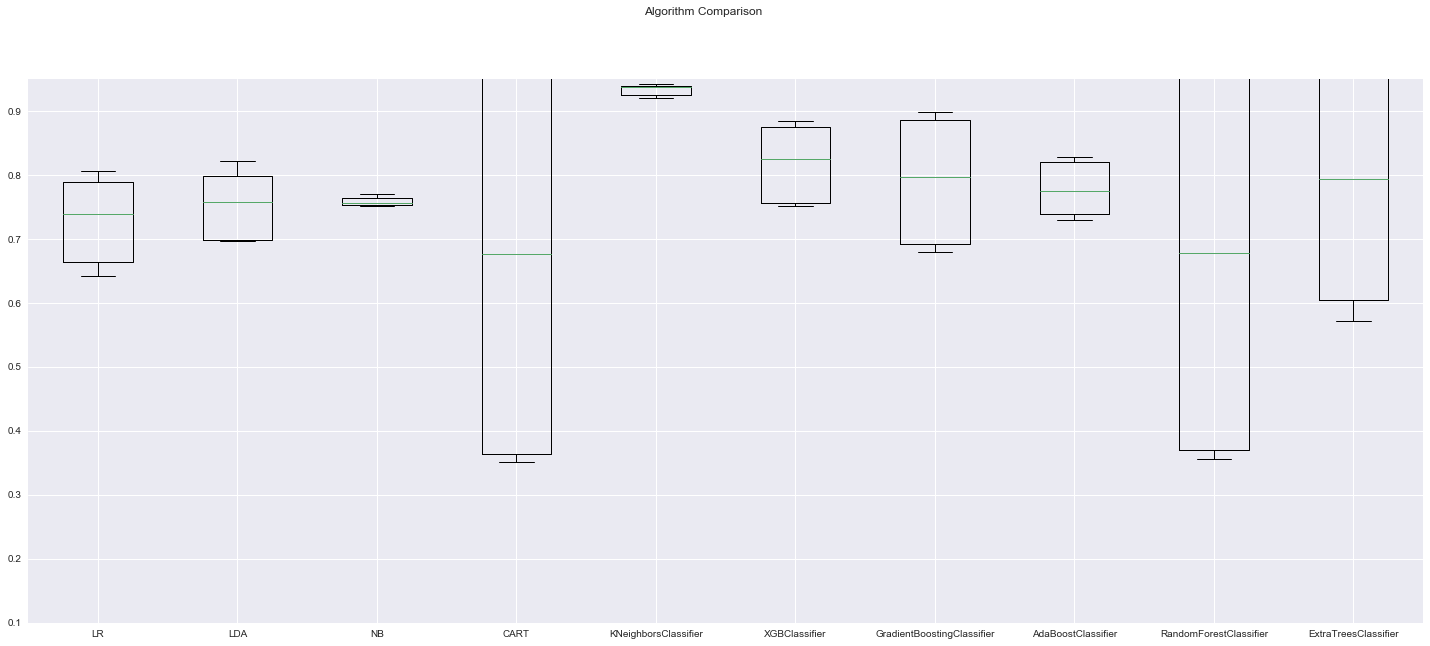

In [86]:
plot_model_score_distribution(results, names)

### Baseline Classifier

In [87]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=25, random_state=12)
clf_rf.fit(x_train_res, y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=12, verbose=0, warm_start=False)

In [88]:
# the validation and test results are similar, indicating that the up-sampling process has not corrupted 
# the training sample by correcting the class imbalance.

from sklearn.metrics import recall_score

print('Validation Results')
print(clf_rf.score(x_val, y_val))
print(recall_score(y_val, clf_rf.predict(x_val)))
print('\nTest Results')
print(clf_rf.score(test_features, test_target))
print(recall_score(test_target, clf_rf.predict(test_features)))

Validation Results
0.954463119761
0.195936139332

Test Results
0.952799787694
0.181585677749


## Tuning

In [89]:
def local_cv(model, params):
    param_grid = params
    kfold = KFold(n_splits=num_folds, random_state=seed)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid_result = grid.fit(x_train_res, y_train_res)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    for params, mean_score, scores in grid_result.grid_scores_:
        print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

### XGB Classifier

In [90]:
xgb.XGBClassifier().get_params().keys()

dict_keys(['base_score', 'colsample_bylevel', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'nthread', 'objective', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample'])

In [91]:
params = {"max_depth":[2], "n_estimators":[36,37,38], "learning_rate":[.04]}
local_cv(xgb.XGBClassifier(), params)

Best: 0.868353 using {'learning_rate': 0.04, 'max_depth': 2, 'n_estimators': 37}
0.868085 (0.059141) with: {'learning_rate': 0.04, 'max_depth': 2, 'n_estimators': 36}
0.868353 (0.058877) with: {'learning_rate': 0.04, 'max_depth': 2, 'n_estimators': 37}
0.868171 (0.059061) with: {'learning_rate': 0.04, 'max_depth': 2, 'n_estimators': 38}


In [92]:
clf_rf = xgb.XGBClassifier(n_estimators= 37, learning_rate = .04, max_depth = 2)
clf_rf.fit(x_train_res, y_train_res)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.04, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=37, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [93]:
x_val2 =x_val.as_matrix()

In [94]:
test_features2 = test_features.as_matrix()

In [95]:
from sklearn.metrics import recall_score

print('Validation Results')
print(clf_rf.score(x_val2, y_val))
print(recall_score(y_val, clf_rf.predict(x_val2)))
print('\nTest Results')
print(clf_rf.score(test_features2, test_target))
print(recall_score(test_target, clf_rf.predict(test_features2)))

Validation Results
0.55701588104
0.901306240929

Test Results
0.56067786329
0.878516624041


### kNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
KNeighborsClassifier().get_params().keys()

In [97]:
# try using alternate weights, e.g. uniform vs distance

params = {"n_neighbors":[9],"weights":['uniform','distance']}
local_cv(KNeighborsClassifier(), params)

Best: 0.935627 using {'n_neighbors': 9, 'weights': 'uniform'}
0.935627 (0.008078) with: {'n_neighbors': 9, 'weights': 'uniform'}
0.894726 (0.055464) with: {'n_neighbors': 9, 'weights': 'distance'}


In [98]:
clf_rf = KNeighborsClassifier(n_neighbors = 9,weights = 'uniform')
clf_rf.fit(x_train_res, y_train_res)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')

In [99]:
from sklearn.metrics import recall_score

print('Validation Results')
print(clf_rf.score(x_val2, y_val))
print(recall_score(y_val, clf_rf.predict(x_val2)))
print('\nTest Results')
print(clf_rf.score(test_features2, test_target))
print(recall_score(test_target, clf_rf.predict(test_features2)))

Validation Results
0.834913012343
0.571843251089

Test Results
0.842059369906
0.56010230179


### Gradient Boosting Classifier

In [100]:
from sklearn.ensemble import GradientBoostingClassifier
GradientBoostingClassifier().get_params().keys()

dict_keys(['criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'presort', 'random_state', 'subsample', 'verbose', 'warm_start'])

In [101]:
params = {"learning_rate":[.04,.05],"max_depth":[3], "n_estimators":[29,30,31]}
local_cv(GradientBoostingClassifier(), params)

Best: 0.840431 using {'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 31}
0.836849 (0.081099) with: {'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 29}
0.839720 (0.078879) with: {'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 30}
0.840431 (0.076960) with: {'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 31}
0.837999 (0.066380) with: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 29}
0.839073 (0.063498) with: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 30}
0.838869 (0.062520) with: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 31}


In [102]:
clf_rf = GradientBoostingClassifier(n_estimators= 31, learning_rate = .04, max_depth = 3)
clf_rf.fit(x_train_res, y_train_res)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.04, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=31,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [103]:
from sklearn.metrics import recall_score

print('Validation Results')
print(clf_rf.score(x_val2, y_val))
print(recall_score(y_val, clf_rf.predict(x_val2)))
print('\nTest Results')
print(clf_rf.score(test_features2, test_target))
print(recall_score(test_target, clf_rf.predict(test_features2)))

Validation Results
0.628038249294
0.838896952104

Test Results
0.630928460401
0.832480818414


### Extra Trees Classifier

In [104]:
from sklearn.ensemble import ExtraTreesClassifier
ExtraTreesClassifier().get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [105]:
params = {"max_depth":[2], "n_estimators":[64,65,66]}
local_cv(ExtraTreesClassifier(), params)

Best: 0.755394 using {'max_depth': 2, 'n_estimators': 65}
0.751985 (0.015095) with: {'max_depth': 2, 'n_estimators': 64}
0.755394 (0.015914) with: {'max_depth': 2, 'n_estimators': 65}
0.753792 (0.016810) with: {'max_depth': 2, 'n_estimators': 66}


In [106]:
clf_rf = ExtraTreesClassifier(n_estimators= 65, max_depth = 2)
clf_rf.fit(x_train_res, y_train_res)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=2, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=65, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [107]:
from sklearn.metrics import recall_score

print('Validation Results')
print(clf_rf.score(x_val2, y_val))
print(recall_score(y_val, clf_rf.predict(x_val2)))
print('\nTest Results')
print(clf_rf.score(test_features2, test_target))
print(recall_score(test_target, clf_rf.predict(test_features2)))

Validation Results
0.627111504276
0.743105950653

Test Results
0.625507070554
0.754475703325


## Test

In [109]:
# create the sub models
estimators = []

model1 = xgb.XGBClassifier(n_estimators= 37, learning_rate = .04, max_depth = 2)
estimators.append(('XGBClassifier', model1))
# model2 = ExtraTreesClassifier(n_estimators= 65, max_depth = 2)
# estimators.append(('ExtraTreesClassifier', model2))
model2 = KNeighborsClassifier(n_neighbors = 9,weights = 'uniform')
estimators.append(('KNeighborsClassifier', model2))
model3 = GradientBoostingClassifier(n_estimators= 31, learning_rate = .04, max_depth = 3)
estimators.append(('GradientBoostingClassifier', model3))

# create the ensemble model
ensemble = VotingClassifier(estimators, voting='soft',weights =[6,1,4])
results = cross_validation.cross_val_score(ensemble, x_train_res, y_train_res, cv=kfold,scoring=scoring) 
print('Training Results')
print(results)
print('Average Train Score')
print(results.mean())

ensemble.fit(x_train_res, y_train_res)

print('Validation Results')
print(ensemble.score(x_val2, y_val))
print(recall_score(y_val, ensemble.predict(x_val2)))
print('\nTest Results')
print(ensemble.score(test_features2, test_target))
print(recall_score(test_target, ensemble.predict(test_features2)))

Training Results
[ 0.93739968  0.94027304  0.93136472  0.93579595  0.92684887  0.92401061
  0.89507691  0.89418487  0.89247312  0.90028449]
Average Train Score
0.917771226748
Validation Results
0.685664939551
0.814223512337

Test Results
0.691208249611
0.806905370844


### Feature Importance

In [110]:
model1.fit(x_train_res, y_train_res,eval_metric='logloss')

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.04, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=37, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

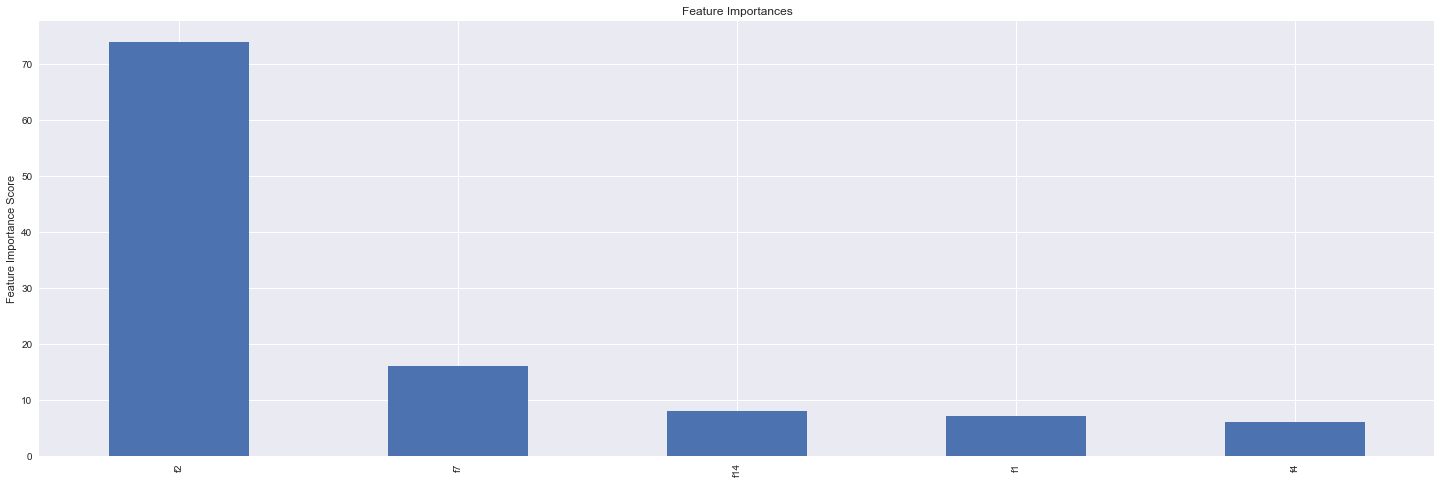

In [111]:
feat_imp = pd.Series(model1.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances',figsize=(25,8))
plt.ylabel('Feature Importance Score');

In [112]:
# end_year, phd_age, other, earliest_country, affiliation_role are relevant features in primary model
# correctly classified 65% of scientists and 81% of US Migrants in test group
x_train.head()

,earliest_year,earliest_country,end_year,affiliation_type,affiliation_role,has_phd,phd_year,phd_age,life_science,physical_science,social_science,engineering,humanities,education,other
orcid_id,,,,,,,,,,,,,,,
0000-0001-9837-6433,1995.0,132,1998.0,1,69180,0,0.0,0.0,0,0,0,0,0,0,1
0000-0002-2206-2961,2004.0,149,2016.0,1,34656,0,0.0,0.0,0,0,0,0,0,0,1
0000-0002-0240-5584,1992.0,101,1996.0,0,60095,0,0.0,0.0,0,0,0,0,0,0,1
0000-0002-0669-3165,2008.0,26,2012.0,0,54529,0,0.0,0.0,1,0,0,0,0,0,0
0000-0002-4865-3903,2011.0,56,2016.0,1,66518,0,0.0,0.0,0,0,0,0,0,0,1
